In [4]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Loading data to tf.dataset

In [7]:
# Loadig data to tf.dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "valid",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

Found 17572 files belonging to 38 classes.


In [5]:
len(dataset)

550

# Visualization of the loaded images


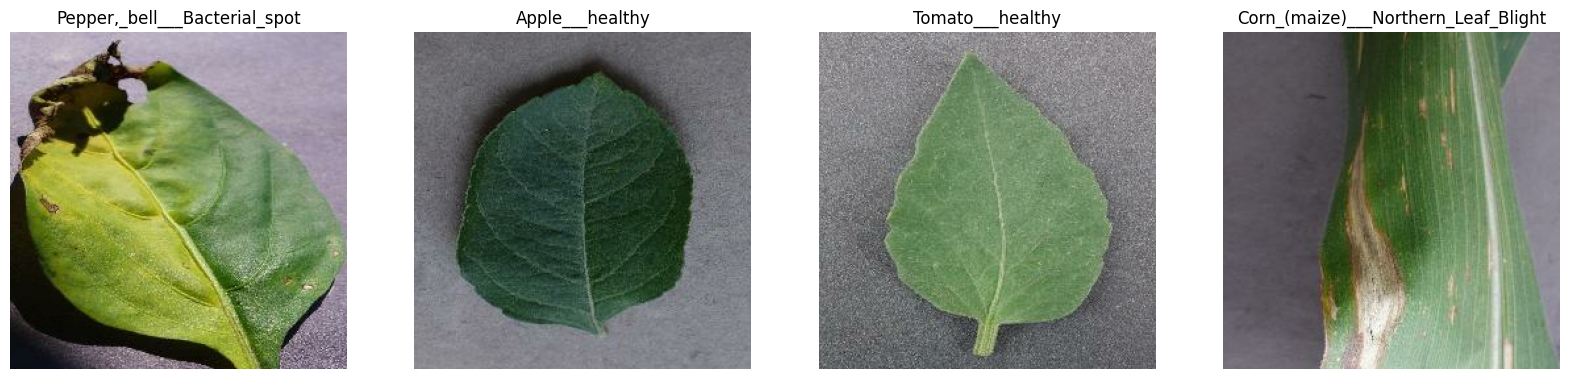

In [8]:
# Visualizing the first 4 images

plt.figure(figsize=(20,20))

for image_batch, label_batch in dataset.take(1):
  for i in range(4):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(dataset.class_names[label_batch[i]])
    plt.axis('off')

# Splitting the dataset into training and validation *sets*


In [12]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


# Preprocess the data

In [13]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, label

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)


# Creating the model using Convolutional Neural Network

---



In [14]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(38, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


# Training the model

In [15]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10)


Epoch 1/10
440/440 [==============================] - 810s 2s/step - loss: 2.0334 - accuracy: 0.4279 - val_loss: 1.1887 - val_accuracy: 0.6409
Epoch 2/10
440/440 [==============================] - 801s 2s/step - loss: 0.7737 - accuracy: 0.7629 - val_loss: 0.9214 - val_accuracy: 0.7128
Epoch 3/10
440/440 [==============================] - 1015s 2s/step - loss: 0.3914 - accuracy: 0.8746 - val_loss: 0.9228 - val_accuracy: 0.7577
Epoch 4/10
440/440 [==============================] - 891s 2s/step - loss: 0.1928 - accuracy: 0.9394 - val_loss: 0.8821 - val_accuracy: 0.7978
Epoch 5/10
440/440 [==============================] - 983s 2s/step - loss: 0.1431 - accuracy: 0.9546 - val_loss: 0.9047 - val_accuracy: 0.7806
Epoch 6/10
440/440 [==============================] - 951s 2s/step - loss: 0.1128 - accuracy: 0.9650 - val_loss: 1.0635 - val_accuracy: 0.7861
Epoch 7/10
440/440 [==============================] - 1081s 2s/step - loss: 0.0879 - accuracy: 0.9724 - val_loss: 0.9506 - val_accuracy: 0.80

# Visualize the training and validation accuracy and loss

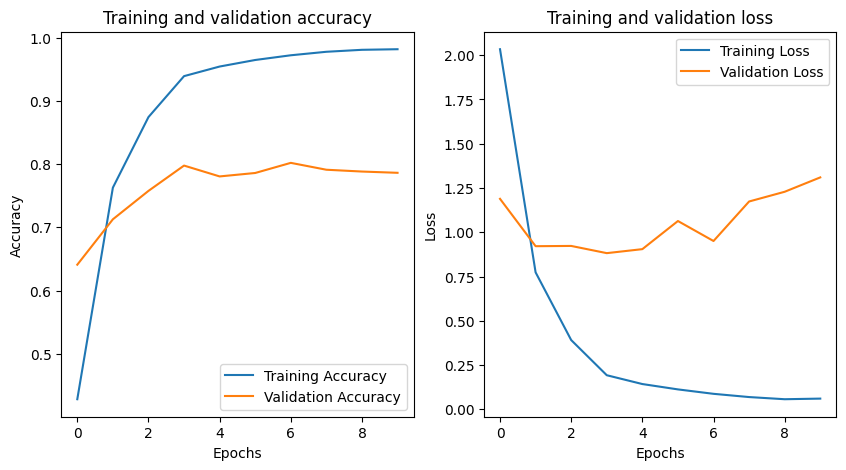

In [30]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [43]:
# test_loss, test_acc = model.evaluate(test_dataset)
# print(f"Test accuracy: {test_acc:.2f}")

# test_dataset = tf.keras.utils.image_dataset_from_directory(
#     'test',
#     batch_size=32,
#     image_size=(256, 256),
#     shuffle=False,
# )

test_loss, test_accuracy = model.evaluate(val_dataset)

print(f'Test accuracy: {test_accuracy}')


110/110 [==============================] - 42s 319ms/step - loss: 1.3108 - accuracy: 0.7861
Test accuracy: 0.7860824465751648


In [31]:
# Save model
model.save('crop_disease_model.h5')

In [9]:
# Load model

loaded_model = tf.keras.models.load_model('crop_disease_model.h5')

In [46]:
# # Fine-tuning with data augmentation and a pre-trained model
# data_augmentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip('horizontal'),
#     layers.experimental.preprocessing.RandomRotation(0.1),
# ])

# base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3),
#                                                include_top=False,
#                                                weights='imagenet')

# inputs = tf.keras.Input(shape=(256, 256, 3))

# x = data_augmentation(inputs)
# x = base_model(x, training=False)
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(128, activation='relu')(x)
# outputs = layers.Dense(38, activation='softmax')(x)

# fine_tuned_model = tf.keras.Model(inputs, outputs)


In [47]:
# # Compile and train the fine-tuned model
# fine_tuned_model.compile(optimizer='adam',
#                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                          metrics=['accuracy'])

# fine_tuned_history = fine_tuned_model.fit(train_dataset,
#                                           validation_data=val_dataset,
#                                           epochs=10)


In [ ]:
# Creating an API for the AI model using Flask

In [ ]:
import io
import os
import random
import numpy as np
import tensorflow as tf
from flask import Flask, request, jsonify, render_template, send_from_directory
from scipy.special import softmax


app = Flask(__name__)

# Load the trained model
model = tf.keras.models.load_model('crop_disease_model.h5')

# Load the dataset to get the class names
dataset_directory = 'valid'

dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)
class_names = dataset.class_names


@app.route('/')
def index():
    return render_template('index.html')


@app.route('/favicon.ico')
def favicon():
    return send_from_directory(os.path.join(app.root_path, 'static'),
                               'favicon.ico', mimetype='image/vnd.microsoft.icon')


@app.route('/predict', methods=['POST'])
def predict():
    img = request.files['image']
    img_bytes = io.BytesIO(img.read())
    image = tf.keras.preprocessing.image.load_img(img_bytes, target_size=(256, 256))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    predictions = model.predict(input_arr)
    predicted_class = np.argmax(predictions[0])

    class_name = class_names[predicted_class]
    similar_images = get_similar_images(class_name)
    
    # Get the confidence percentage
#     probabilities = softmax(predictions[0])
#     confidence_percentage = probabilities[predicted_class] * 100

    return jsonify({"class": class_name, "confidence": 100, "similar_images": similar_images})


@app.route('/images/<path:filename>', methods=['GET'])
def serve_image(filename):
    return send_from_directory(os.path.join(dataset_directory), filename)


def get_similar_images(class_name):
    class_directory = os.path.join(dataset_directory, class_name)
    all_images = os.listdir(class_directory)
    random.shuffle(all_images)
    selected_images = all_images[:5]
    image_paths = [os.path.join(class_name, img) for img in selected_images]
    return image_paths


if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)
    

2023-04-04 13:46:18.540060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 13:46:20.574819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 13:46:20.575986: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 17572 files belonging to 38 classes.
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.156.229:5000
Press CTRL+C to quit
127.0.0.1 - - [04/Apr/2023 13:46:26] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 149ms/step


127.0.0.1 - - [04/Apr/2023 13:46:32] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:46:32] "GET /images/Tomato___healthy/ceb2bf82-b22d-43bb-9a32-cac11e19febd___RS_HL%200406.JPG HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:46:32] "GET /images/Tomato___healthy/1dae303e-6545-4c87-8c95-8805108f5282___RS_HL%200437_180deg.JPG HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:46:32] "GET /images/Tomato___healthy/0764ce38-ecb9-4046-88d9-c8f176c6ee8b___GH_HL%20Leaf%20423.JPG HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:46:32] "GET /images/Tomato___healthy/3b4a011c-68ae-4b84-90b5-27ef4b2d3447___GH_HL%20Leaf%20255.JPG HTTP/1.1" 304 -
127.0.0.1 - - [04/Apr/2023 13:46:32] "GET /images/Tomato___healthy/0c8c9c80-b7e0-47a7-81d3-b5a2174e545d___GH_HL%20Leaf%20496.1_new30degFlipLR.JPG HTTP/1.1" 200 -


1/1 [==============================] - 0s 43ms/step


127.0.0.1 - - [04/Apr/2023 13:46:50] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:46:50] "GET /images/Tomato___healthy/b3e76dfe-eeb0-4edf-a93c-bb7964ff57eb___GH_HL%20Leaf%20210.4.JPG HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:46:50] "GET /images/Tomato___healthy/3e6c73ad-cfcb-4614-b927-150c2c642c9e___RS_HL%200074_180deg.JPG HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:46:50] "GET /images/Tomato___healthy/3c8a4977-eab9-4639-b12a-c1c42c7258f3___RS_HL%200432_flipTB.JPG HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:46:50] "GET /images/Tomato___healthy/3d59c273-6439-4c0d-b5ac-3738faca5d2a___RS_HL%200413_newPixel25.JPG HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:46:50] "GET /images/Tomato___healthy/719352b5-1b4c-41e5-a517-3dfde18c13ef___RS_HL%200300.JPG HTTP/1.1" 200 -


1/1 [==============================] - 0s 42ms/step


127.0.0.1 - - [04/Apr/2023 13:47:01] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:47:01] "GET /images/Potato___Early_blight/b7157976-61c2-4366-87c5-e3de23aa7c10___RS_Early.B%207227.JPG HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:47:01] "GET /images/Potato___Early_blight/a02f78b3-da52-400a-ab11-7184df9ea485___RS_Early.B%208403_flipTB.JPG HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:47:01] "GET /images/Potato___Early_blight/a2fe15c2-1900-4fbd-9e69-771b1693cc68___RS_Early.B%207398_180deg.JPG HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:47:01] "GET /images/Potato___Early_blight/6ad3d424-3e81-4b18-a029-4a20884c4ada___RS_Early.B%208380.JPG HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2023 13:47:01] "GET /images/Potato___Early_blight/ae5a9be8-5bd6-4542-8766-6c7bb8c61ded___RS_Early.B%208182_flipTB.JPG HTTP/1.1" 200 -
